# Implementing a Neural Network for CIFAR dataset - Convolutional Networks

Remember ex2? Now, you will try to improve it by using CNNs. Using conovolutioal layers when working with images should improve your results.

All the code is written for you (loading images, training loop...), you shoiuld come up with a CNN from your own.

As usual, you can try to add also augmentations, or other advanced tools you learnt (weight decay, learning rate, regularizations...)


## Loading CIFAR dataset

In [1]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy

# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])
# transform_train = transforms.Compose(
#     [transforms.ToTensor()])
transform_val = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 16 # was 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

100%|██████████| 170498071/170498071 [00:13<00:00, 12581852.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In [3]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

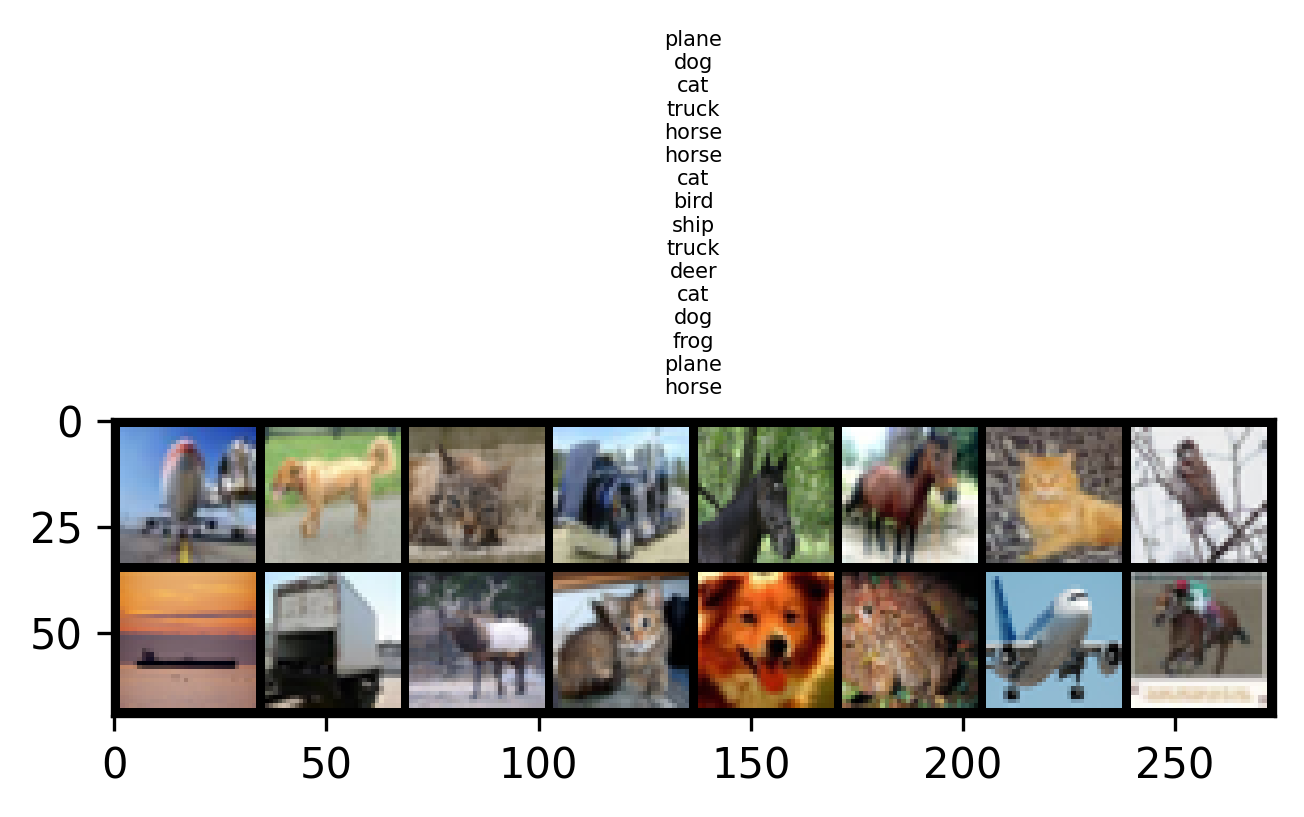

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## CNN (100 points)

You should define a CNN

In [5]:
import torch.nn.functional as F

In [6]:
#!pip install torchsummary 
from torchsummary import summary

In [7]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])


## Setting up 3 different CNN models

### Model 1

In [9]:
# Here is your main code



class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 3 input image channel, 32 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # 6*6 from image dimension
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model_1 = NeuralNetwork().to(device)
print(model_1)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
summary(model_1.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
            Conv2d-2           [-1, 64, 12, 12]          18,496
            Linear-3                  [-1, 128]         295,040
            Linear-4                   [-1, 10]           1,290
Total params: 317,258
Trainable params: 317,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.26
Params size (MB): 1.21
Estimated Total Size (MB): 1.48
----------------------------------------------------------------


### Model 2 - more convolution layers

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 3 input image channel, 32 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 8*8 from image dimension
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # First convolution without max pooling
        x = F.relu(self.conv1(x))
        # Second convolution with Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # First convolution without max pooling
        x = F.relu(self.conv3(x))
        # Second convolution with Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        # 2 Dense layers
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
model_2 = NeuralNetwork().to(device)
print(model_2)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
summary(model_2.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]           9,248
            Conv2d-3           [-1, 64, 16, 16]          18,496
            Conv2d-4           [-1, 64, 16, 16]          36,928
            Linear-5                  [-1, 128]         524,416
            Linear-6                   [-1, 10]           1,290
Total params: 591,274
Trainable params: 591,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 2.26
Estimated Total Size (MB): 3.02
----------------------------------------------------------------


### Model 3 - bigger network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 3 input image channel, 32 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # 8*8 from image dimension
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        # First convolution without max pooling
        x = F.relu(self.conv1(x))
        # Second convolution with Max pooling over a (2, 2) window and dropout
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # First convolution without max pooling
        x = F.relu(self.conv3(x))
        # Second convolution with Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        # 2 Dense layers
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model_3 = NeuralNetwork().to(device)
print(model_3)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
summary(model_3.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Conv2d-3          [-1, 128, 16, 16]          73,856
            Conv2d-4          [-1, 128, 16, 16]         147,584
            Linear-5                  [-1, 256]       2,097,408
            Linear-6                   [-1, 10]           2,570
Total params: 2,340,810
Trainable params: 2,340,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.25
Params size (MB): 8.93
Estimated Total Size (MB): 10.19
----------------------------------------------------------------


### Model 4 - same as 3 with dropout layers

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 3 input image channel, 32 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # 8*8 from image dimension
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        # First convolution without max pooling
        x = F.relu(self.conv1(x))
        # Second convolution with Max pooling over a (2, 2) window and dropout
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # First convolution without max pooling
        x = F.relu(self.conv3(x))
        # Second convolution with Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        # 2 Dense layers
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = self.fc2(x)
        return x

In [16]:
model_4 = NeuralNetwork().to(device)
print(model_4)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## Training Function

In [19]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

## Training the models

### Model 1 (batch size 16):
Best val Acc: 0.6998

In [ ]:
# If a GPU is available, make the model use it
model = model_1.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
#optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 20

In [ ]:
model_1,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/19
----------
train Loss: 1.9702 Acc: 0.2793
val Loss: 1.6253 Acc: 0.4201

Epoch 1/19
----------
train Loss: 1.5262 Acc: 0.4456
val Loss: 1.3978 Acc: 0.5034

Epoch 2/19
----------
train Loss: 1.3429 Acc: 0.5201
val Loss: 1.2829 Acc: 0.5481

Epoch 3/19
----------
train Loss: 1.2086 Acc: 0.5710
val Loss: 1.1719 Acc: 0.5812

Epoch 4/19
----------
train Loss: 1.1116 Acc: 0.6082
val Loss: 1.0759 Acc: 0.6237

Epoch 5/19
----------
train Loss: 1.0382 Acc: 0.6355
val Loss: 1.0740 Acc: 0.6265

Epoch 6/19
----------
train Loss: 0.9742 Acc: 0.6608
val Loss: 0.9944 Acc: 0.6563

Epoch 7/19
----------
train Loss: 0.8611 Acc: 0.7010
val Loss: 0.9312 Acc: 0.6801

Epoch 8/19
----------
train Loss: 0.8407 Acc: 0.7092
val Loss: 0.9243 Acc: 0.6865

Epoch 9/19
----------
train Loss: 0.8309 Acc: 0.7114
val Loss: 0.9152 Acc: 0.6889

Epoch 10/19
----------
train Loss: 0.8203 Acc: 0.7148
val Loss: 0.9194 Acc: 0.6863

Epoch 11/19
----------
train Loss: 0.8128 Acc: 0.7186
val Loss: 0.9053 Acc: 0.6930

Ep

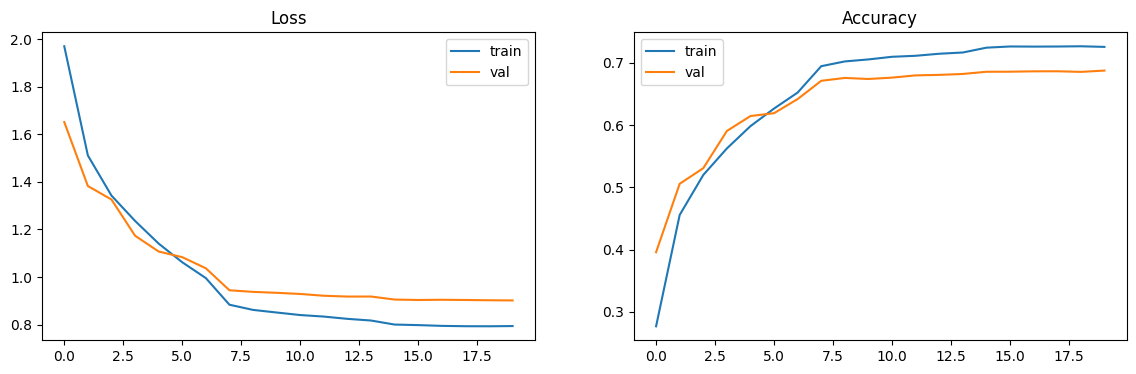

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()

### Model 2 - with batch 16

Best val Acc: 0.715900

In [ ]:
# If a GPU is available, make the model use it
model = model_2.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
#optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 20

In [ ]:
model_2,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/19
----------
train Loss: 2.1345 Acc: 0.2056
val Loss: 1.8169 Acc: 0.3465

Epoch 1/19
----------
train Loss: 1.6583 Acc: 0.4035
val Loss: 1.4593 Acc: 0.4780

Epoch 2/19
----------
train Loss: 1.3956 Acc: 0.4993
val Loss: 1.3105 Acc: 0.5314

Epoch 3/19
----------
train Loss: 1.2579 Acc: 0.5503
val Loss: 1.2033 Acc: 0.5715

Epoch 4/19
----------
train Loss: 1.1291 Acc: 0.5975
val Loss: 1.0752 Acc: 0.6214

Epoch 5/19
----------
train Loss: 1.0167 Acc: 0.6391
val Loss: 1.0383 Acc: 0.6322

Epoch 6/19
----------
train Loss: 0.9209 Acc: 0.6775
val Loss: 0.9352 Acc: 0.6730

Epoch 7/19
----------
train Loss: 0.7622 Acc: 0.7344
val Loss: 0.8697 Acc: 0.6981

Epoch 8/19
----------
train Loss: 0.7362 Acc: 0.7435
val Loss: 0.8620 Acc: 0.7001

Epoch 9/19
----------
train Loss: 0.7215 Acc: 0.7478
val Loss: 0.8523 Acc: 0.7041

Epoch 10/19
----------
train Loss: 0.7064 Acc: 0.7536
val Loss: 0.8476 Acc: 0.7075

Epoch 11/19
----------
train Loss: 0.6909 Acc: 0.7599
val Loss: 0.8426 Acc: 0.7072

Ep

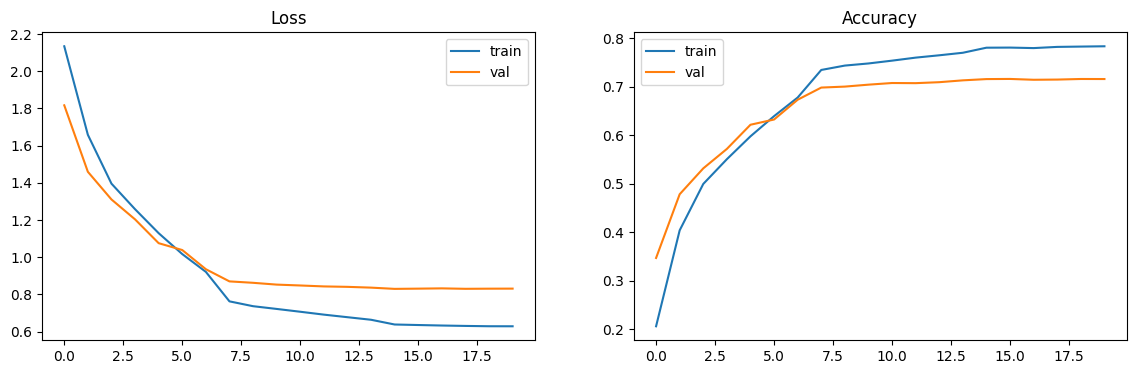

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()

### Model 3 (batch size 16):
Best val Acc: 0.733900

In [ ]:
# If a GPU is available, make the model use it
model = model_3.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
#optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 25

In [ ]:
model_3,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 2.0577 Acc: 0.2398
val Loss: 1.7433 Acc: 0.3835

Epoch 1/24
----------
train Loss: 1.6146 Acc: 0.4188
val Loss: 1.4475 Acc: 0.4708

Epoch 2/24
----------
train Loss: 1.3942 Acc: 0.5000
val Loss: 1.3001 Acc: 0.5370

Epoch 3/24
----------
train Loss: 1.2354 Acc: 0.5604
val Loss: 1.1712 Acc: 0.5813

Epoch 4/24
----------
train Loss: 1.0944 Acc: 0.6100
val Loss: 1.0558 Acc: 0.6274

Epoch 5/24
----------
train Loss: 0.9746 Acc: 0.6553
val Loss: 0.9988 Acc: 0.6493

Epoch 6/24
----------
train Loss: 0.8637 Acc: 0.6955
val Loss: 0.8915 Acc: 0.6869

Epoch 7/24
----------
train Loss: 0.6900 Acc: 0.7620
val Loss: 0.8258 Acc: 0.7126

Epoch 8/24
----------
train Loss: 0.6542 Acc: 0.7735
val Loss: 0.8187 Acc: 0.7164

Epoch 9/24
----------
train Loss: 0.6323 Acc: 0.7813
val Loss: 0.8228 Acc: 0.7180

Epoch 10/24
----------
train Loss: 0.6153 Acc: 0.7871
val Loss: 0.8117 Acc: 0.7238

Epoch 11/24
----------
train Loss: 0.5966 Acc: 0.7929
val Loss: 0.8058 Acc: 0.7236

Ep

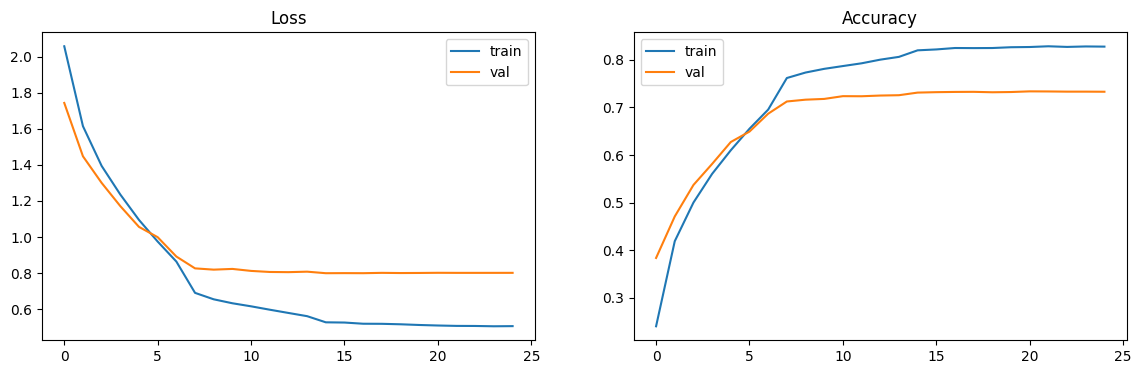

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()

### Model 4 (batch size 16):
Best val Acc: 0.722200

In [ ]:
# If a GPU is available, make the model use it
model = model_4.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
#optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 25

In [ ]:
model_4,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 2.0452 Acc: 0.2430
val Loss: 1.8256 Acc: 0.3389

Epoch 1/24
----------
train Loss: 1.6452 Acc: 0.4110
val Loss: 1.4936 Acc: 0.4660

Epoch 2/24
----------
train Loss: 1.4134 Acc: 0.4925
val Loss: 1.4234 Acc: 0.4940

Epoch 3/24
----------
train Loss: 1.2709 Acc: 0.5453
val Loss: 1.2269 Acc: 0.5594

Epoch 4/24
----------
train Loss: 1.1415 Acc: 0.5922
val Loss: 1.0987 Acc: 0.6098

Epoch 5/24
----------
train Loss: 1.0215 Acc: 0.6383
val Loss: 1.0258 Acc: 0.6334

Epoch 6/24
----------
train Loss: 0.9161 Acc: 0.6795
val Loss: 0.9327 Acc: 0.6714

Epoch 7/24
----------
train Loss: 0.7690 Acc: 0.7305
val Loss: 0.8694 Acc: 0.6948

Epoch 8/24
----------
train Loss: 0.7384 Acc: 0.7423
val Loss: 0.8566 Acc: 0.7010

Epoch 9/24
----------
train Loss: 0.7259 Acc: 0.7464
val Loss: 0.8450 Acc: 0.7053

Epoch 10/24
----------
train Loss: 0.7072 Acc: 0.7522
val Loss: 0.8323 Acc: 0.7100

Epoch 11/24
----------
train Loss: 0.6943 Acc: 0.7583
val Loss: 0.8353 Acc: 0.7069

Ep

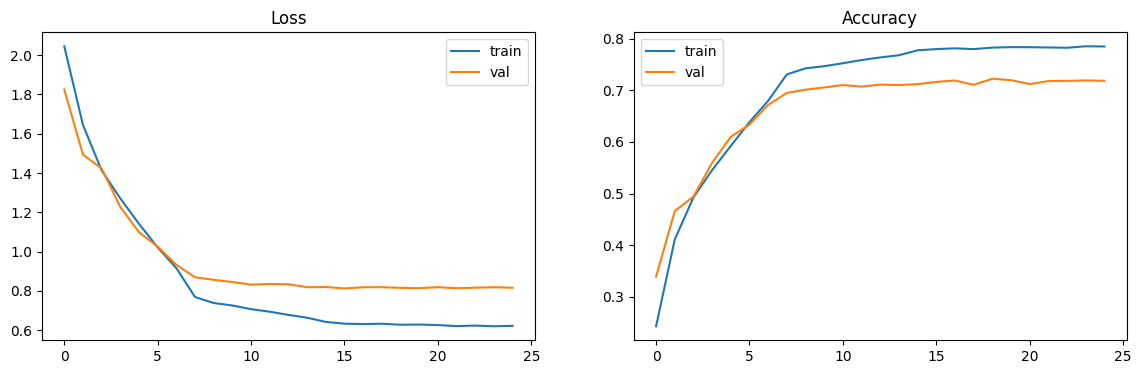

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()

use Adam instead of sgd: recived : Best val Acc: 0.782100


In [17]:
# If a GPU is available, make the model use it
model = model_4.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Adam as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 25

In [20]:
#train
%%time
model_4,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 1.4520 Acc: 0.4741
val Loss: 1.1891 Acc: 0.5772

Epoch 1/24
----------
train Loss: 0.9994 Acc: 0.6489
val Loss: 0.9060 Acc: 0.6874

Epoch 2/24
----------
train Loss: 0.8386 Acc: 0.7062
val Loss: 0.8840 Acc: 0.6979

Epoch 3/24
----------
train Loss: 0.7437 Acc: 0.7390
val Loss: 0.7956 Acc: 0.7213

Epoch 4/24
----------
train Loss: 0.6716 Acc: 0.7645
val Loss: 0.7906 Acc: 0.7325

Epoch 5/24
----------
train Loss: 0.6190 Acc: 0.7839
val Loss: 0.8252 Acc: 0.7261

Epoch 6/24
----------
train Loss: 0.5786 Acc: 0.7986
val Loss: 0.7947 Acc: 0.7477

Epoch 7/24
----------
train Loss: 0.4213 Acc: 0.8526
val Loss: 0.7075 Acc: 0.7745

Epoch 8/24
----------
train Loss: 0.3844 Acc: 0.8646
val Loss: 0.7063 Acc: 0.7756

Epoch 9/24
----------
train Loss: 0.3635 Acc: 0.8733
val Loss: 0.7058 Acc: 0.7795

Epoch 10/24
----------
train Loss: 0.3409 Acc: 0.8813
val Loss: 0.7243 Acc: 0.7755

Epoch 11/24
----------
train Loss: 0.3245 Acc: 0.8871
val Loss: 0.7270 Acc: 0.7787

Ep

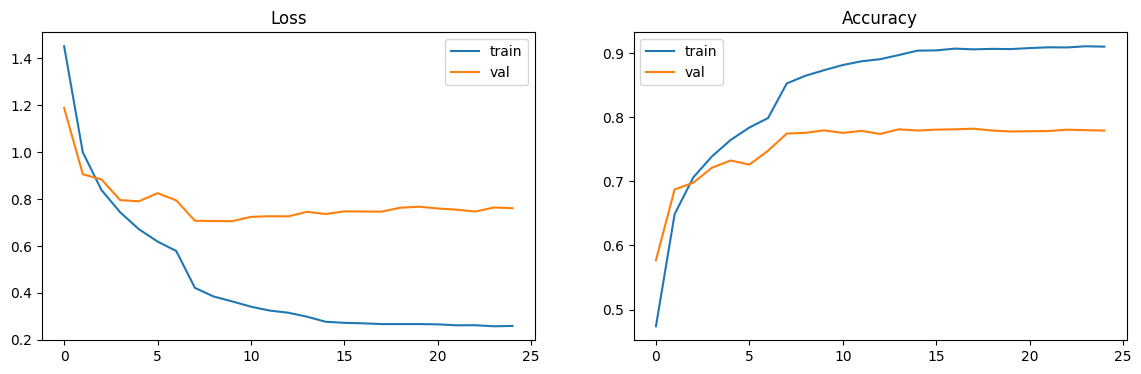

In [21]:
plot_convergence(dict_res,num_epochs ); plt.show()

Summary:

best results were acchived with the biggest cnn model and adam optimazer, in the price of longer time more computational needed.